## Convolutional autoencoders

In [28]:
%load_ext autoreload
%load_ext nb_black
%load_ext autotime
%autoreload 2


from matplotlib import pyplot as plt
import random
import numpy as np
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams["figure.figsize"] = [10, 2]
plt.rcParams["figure.dpi"] = 200

random.seed(42)
np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

### Generate a synthetic time series

<AxesSubplot:>

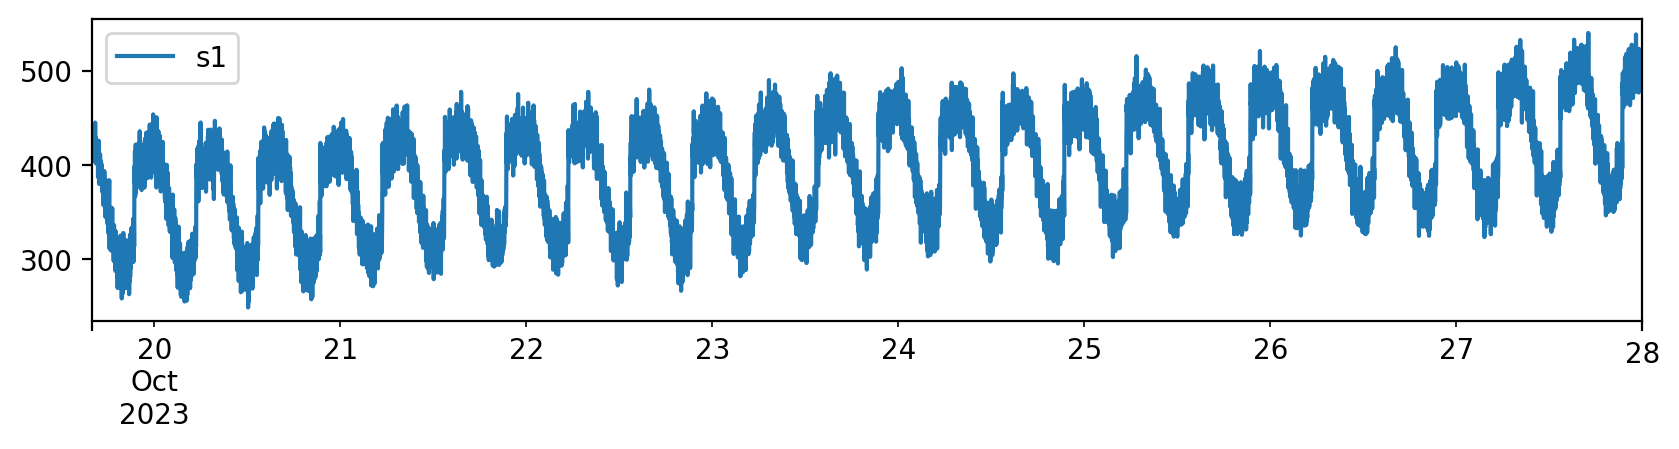

<IPython.core.display.Javascript object>

In [29]:
from numalogic.synthetic import SyntheticTSGenerator
from numalogic.synthetic import AnomalyGenerator

ts_generator = SyntheticTSGenerator(
    seq_len=12000,
    num_series=1,
    freq="T",
    primary_period=480,
    secondary_period=3000,
    seasonal_ts_prob=1.0,
    baseline_range=(200.0, 350.0),
    slope_range=(-0.001, 0.01),
    amplitude_range=(10, 75),
    cosine_ratio_range=(0.5, 0.9),
    noise_range=(10, 15),
)
ts_df = ts_generator.gen_tseries()
ts_df.plot()

### Divide into train, test and validation set

In [30]:
train_df, test_df = ts_generator.train_test_split(ts_df, test_size=2400)
train_df, val_df = ts_generator.train_test_split(train_df, test_size=2000)
train_df.shape, val_df.shape, test_df.shape

((7600, 1), (2000, 1), (2400, 1))

<IPython.core.display.Javascript object>

### Inject synthetic anomalies in the test data
Let's generate a contextual anomaly with a low impact.


In [31]:
anomaly_generator = AnomalyGenerator(
    train_df, anomaly_type="contextual", anomaly_ratio=0.2
)
outlier_test_df = anomaly_generator.inject_anomalies(test_df, cols=["s1"], impact=0.5)

<IPython.core.display.Javascript object>

<AxesSubplot:>

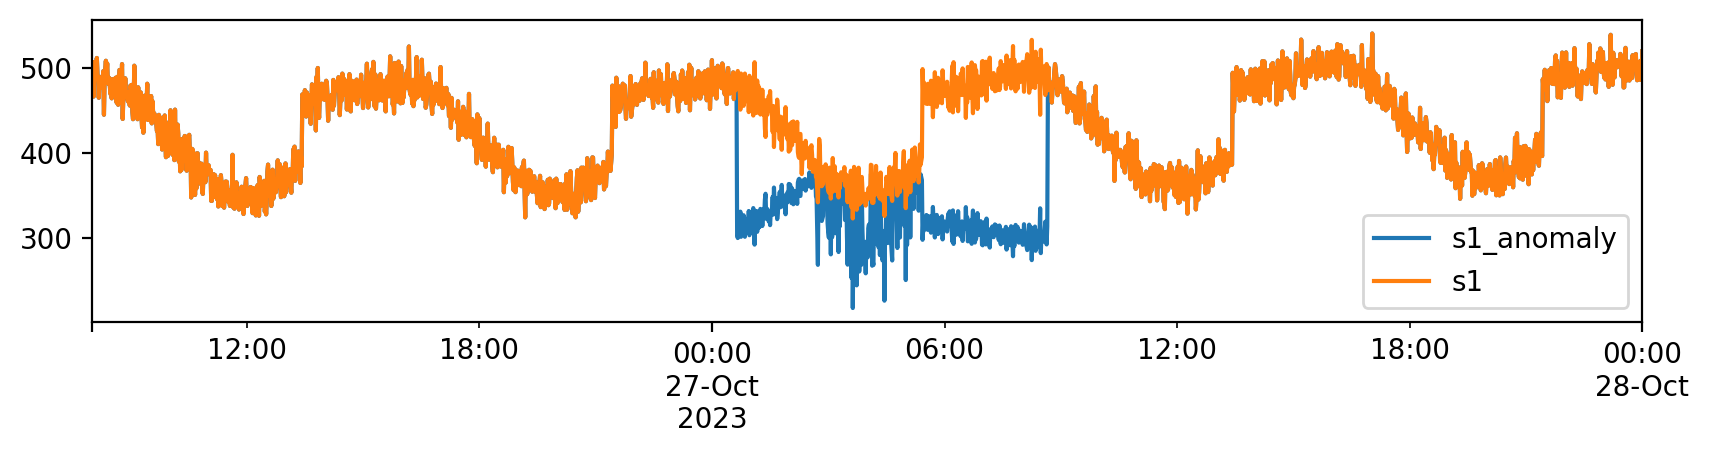

<IPython.core.display.Javascript object>

In [32]:
outlier_test_df.rename(columns={"s1": "s1_anomaly"}, inplace=True)
fig, ax = plt.subplots()
outlier_test_df[["s1_anomaly"]].plot(ax=ax)
test_df.plot(ax=ax)

### Preprocess the data
We will use the Tanh scaler here from numalogic.

In [33]:
from numalogic.transforms import TanhScaler

scaler = TanhScaler()
x_train = scaler.fit_transform(train_df.to_numpy())
x_val = scaler.transform(val_df.to_numpy())
x_test = scaler.transform(outlier_test_df[["s1_anomaly"]].to_numpy())
x_test_good = scaler.transform(test_df.to_numpy())

<IPython.core.display.Javascript object>

### Define model training parameters
First, we will prepare some torch datasets

In [34]:
from numalogic.tools.data import StreamingDataset
from torch.utils.data import DataLoader


SEQ_LEN = 12
BATCH_SIZE = 64
MAX_EPOCHS = 40

train_dataset = StreamingDataset(x_train, seq_len=SEQ_LEN)
val_dataset = StreamingDataset(x_val, seq_len=SEQ_LEN)
test_dataset = StreamingDataset(x_test, seq_len=SEQ_LEN)

<IPython.core.display.Javascript object>

### Let's define 1st convolutional model

In [35]:
from numalogic.models.autoencoder.variants import Conv1dAE
from numalogic.models.autoencoder import TimeseriesTrainer

model_1 = Conv1dAE(seq_len=SEQ_LEN, in_channels=1, enc_channels=(16, 32, 8), enc_kernel_sizes=3)
print(model_1)

Conv1dAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): ConvBlock(
        (conv): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
        (bnorm): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ConvBlock(
        (conv): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (bnorm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv1d(32, 8, kernel_size=(3,), stride=(1,), padding=(1,))
      (5): ReLU()
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): ConvTransposeBlock(
        (convtranspose): ConvTranspose1d(8, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (bnorm): BatchN

<IPython.core.display.Javascript object>

In [36]:
trainer = TimeseriesTrainer(max_epochs=MAX_EPOCHS, enable_progress_bar=True)
trainer.fit(model_1, train_dataloaders=DataLoader(train_dataset, batch_size=BATCH_SIZE))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=40` reached.


<IPython.core.display.Javascript object>

### Fetch the reconstruction error for model 1

In [37]:
train_reconerr_1 = trainer.predict(
    model_1, dataloaders=DataLoader(train_dataset, batch_size=BATCH_SIZE)
).numpy()
val_reconerr_1 = trainer.predict(
    model_1, dataloaders=DataLoader(val_dataset, batch_size=BATCH_SIZE)
).numpy()
test_reconerr_1 = trainer.predict(
    model_1, dataloaders=DataLoader(test_dataset, batch_size=BATCH_SIZE)
).numpy()

<IPython.core.display.Javascript object>

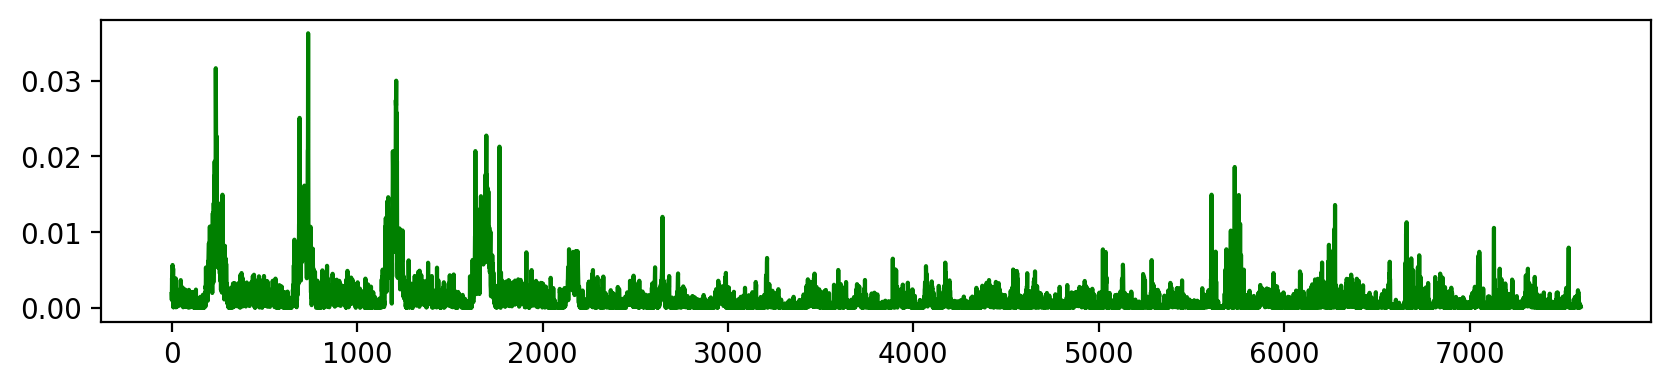

<IPython.core.display.Javascript object>

In [38]:
fig = plt.plot(train_reconerr_1, color="g")

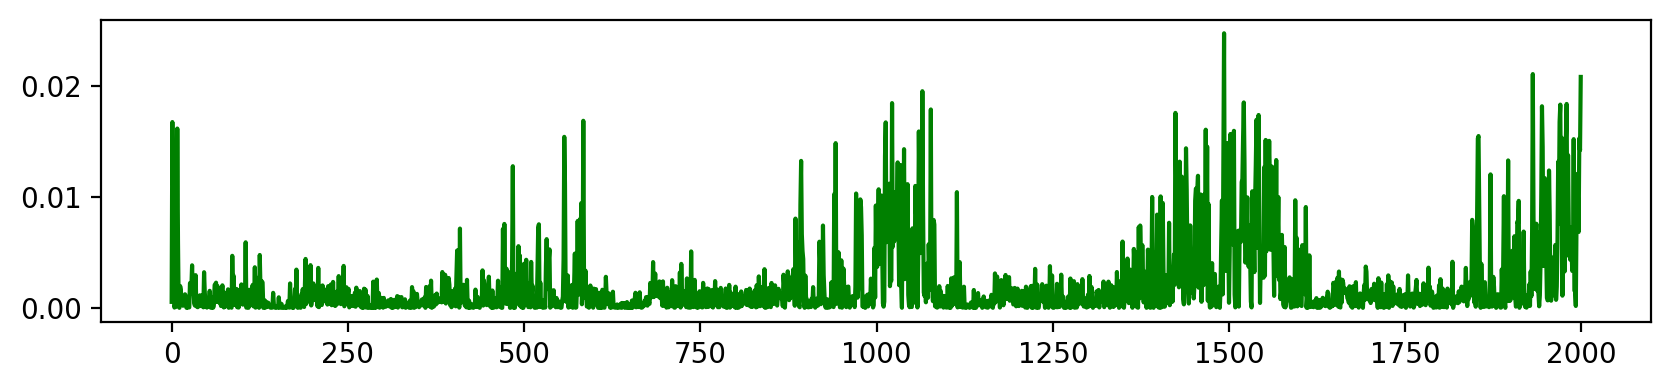

<IPython.core.display.Javascript object>

In [39]:
fig = plt.plot(val_reconerr_1, color="g")

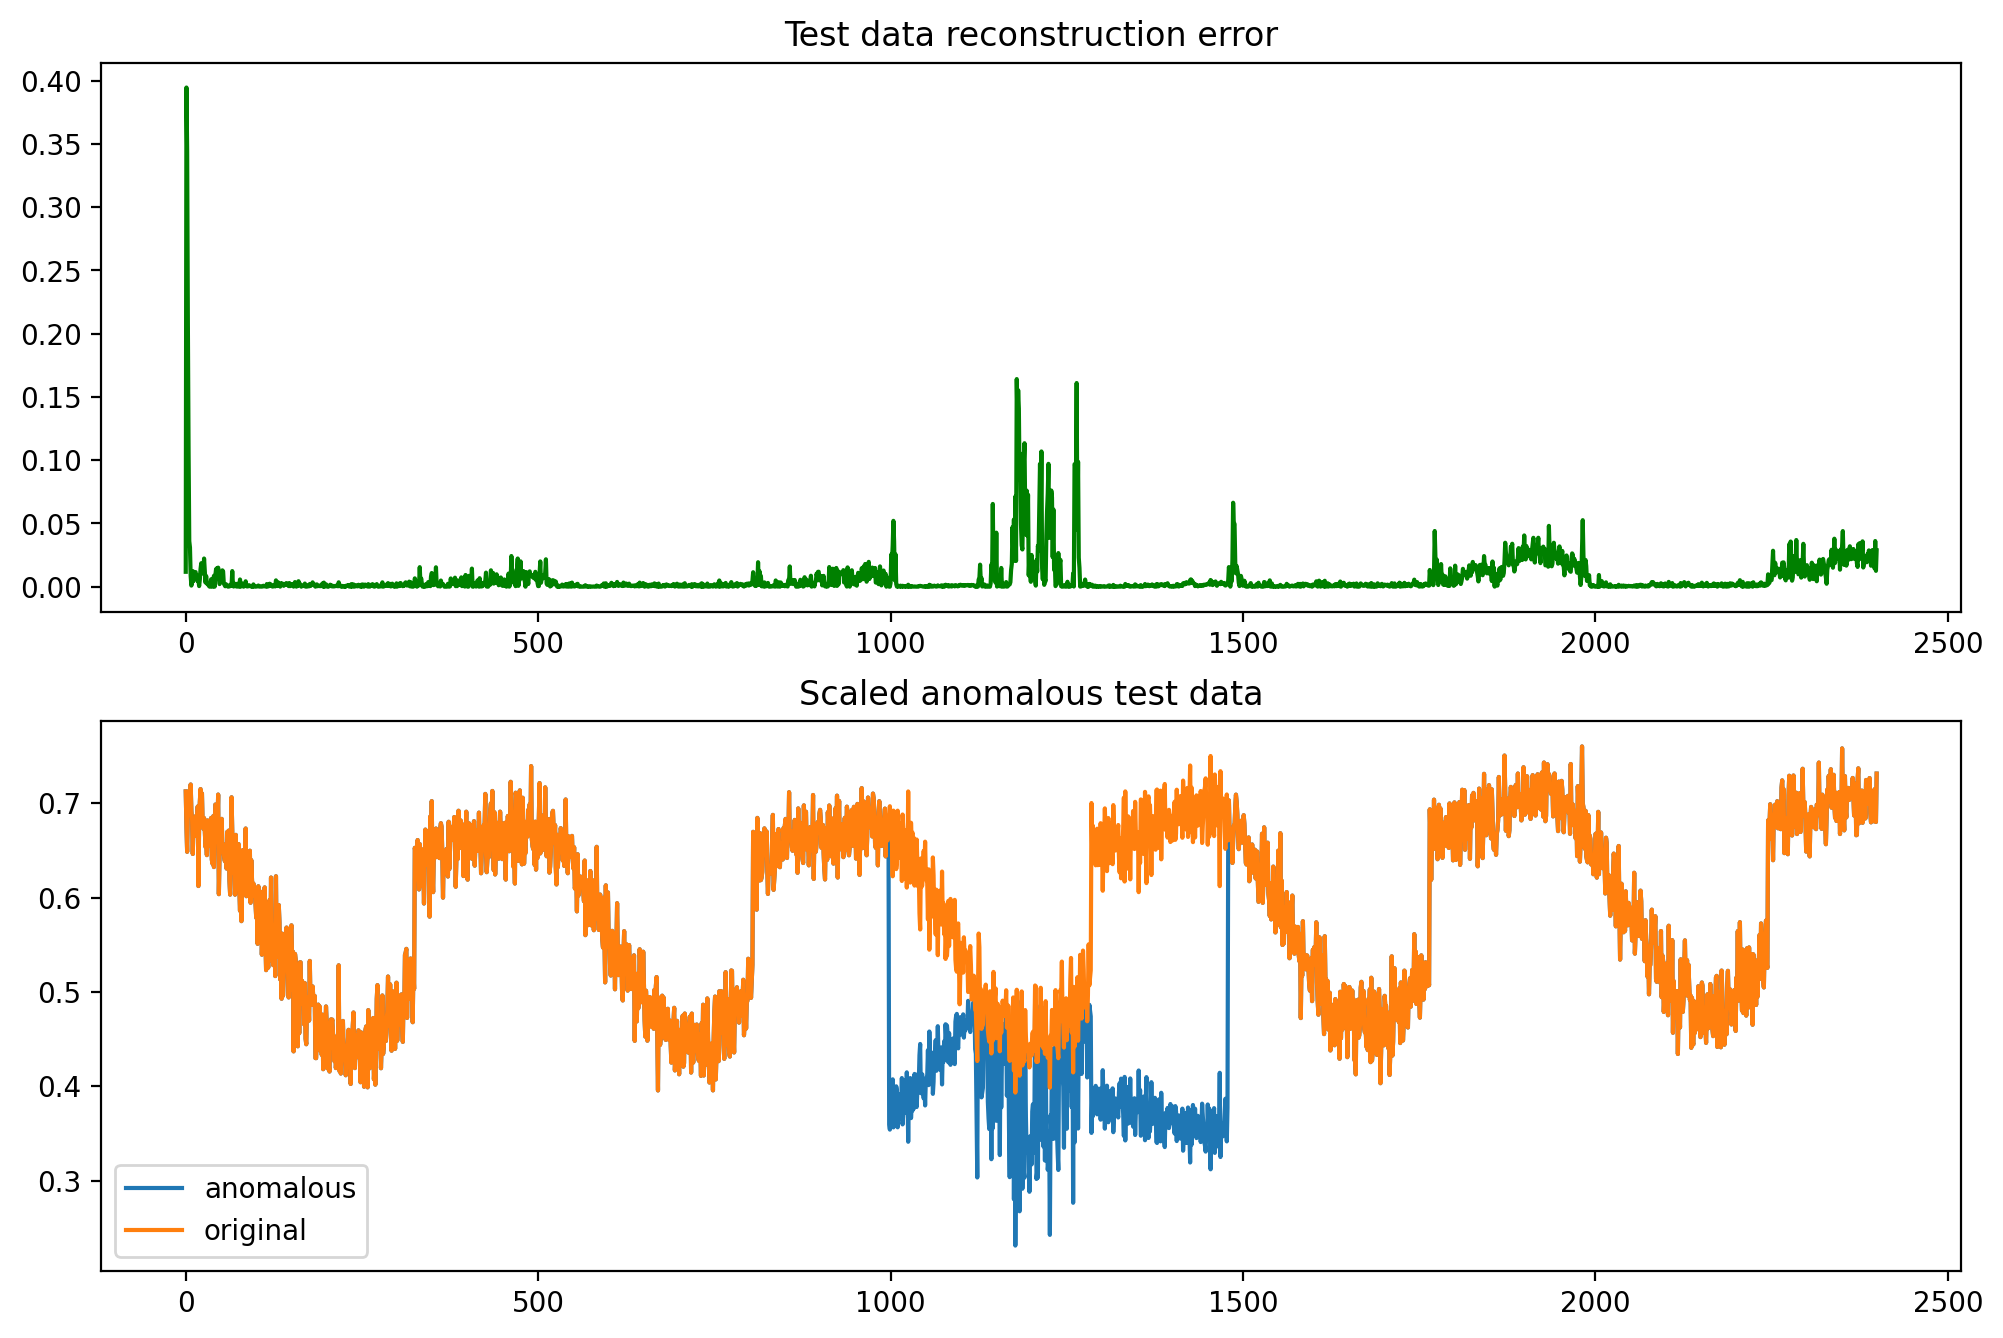

<IPython.core.display.Javascript object>

In [40]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
axes[0].set_title("Test data reconstruction error")
axes[1].set_title("Scaled anomalous test data")
_ = axes[0].plot(test_reconerr_1, color="g")
_ = axes[1].plot(x_test, label="anomalous")
_ = axes[1].plot(x_test_good, label="original")
plt.legend()

## Model 2
Using a 2 conv layer network in the encoder and decoder, along with sigmoid activation function,

In [41]:
model_2 = Conv1dAE(seq_len=SEQ_LEN, in_channels=1, enc_channels=(16, 8), enc_kernel_sizes=(5, 3), dec_activation="sigmoid")
model_2

Conv1dAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): ConvBlock(
        (conv): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(1,))
        (bnorm): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): Conv1d(16, 8, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): ReLU()
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): ConvTransposeBlock(
        (convtranspose): ConvTranspose1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
        (bnorm): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): Upsample(scale_factor=2.0, mode='linear')
      (2): ConvTranspose1d(16, 1, kernel_size=(5,), stride=(1,), padding=(1,))
      (3): Sigmoid()
    )
  )
)

<IPython.core.display.Javascript object>

In [42]:
trainer = TimeseriesTrainer(max_epochs=MAX_EPOCHS, enable_progress_bar=True)
trainer.fit(model_2, train_dataloaders=DataLoader(train_dataset, batch_size=BATCH_SIZE))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=40` reached.


<IPython.core.display.Javascript object>

In [43]:
train_reconerr_2 = trainer.predict(
    model_2, dataloaders=DataLoader(train_dataset, batch_size=BATCH_SIZE)
).numpy()
val_reconerr_2 = trainer.predict(
    model_2, dataloaders=DataLoader(val_dataset, batch_size=BATCH_SIZE)
).numpy()
test_reconerr_2 = trainer.predict(
    model_2, dataloaders=DataLoader(test_dataset, batch_size=BATCH_SIZE)
).numpy()

<IPython.core.display.Javascript object>

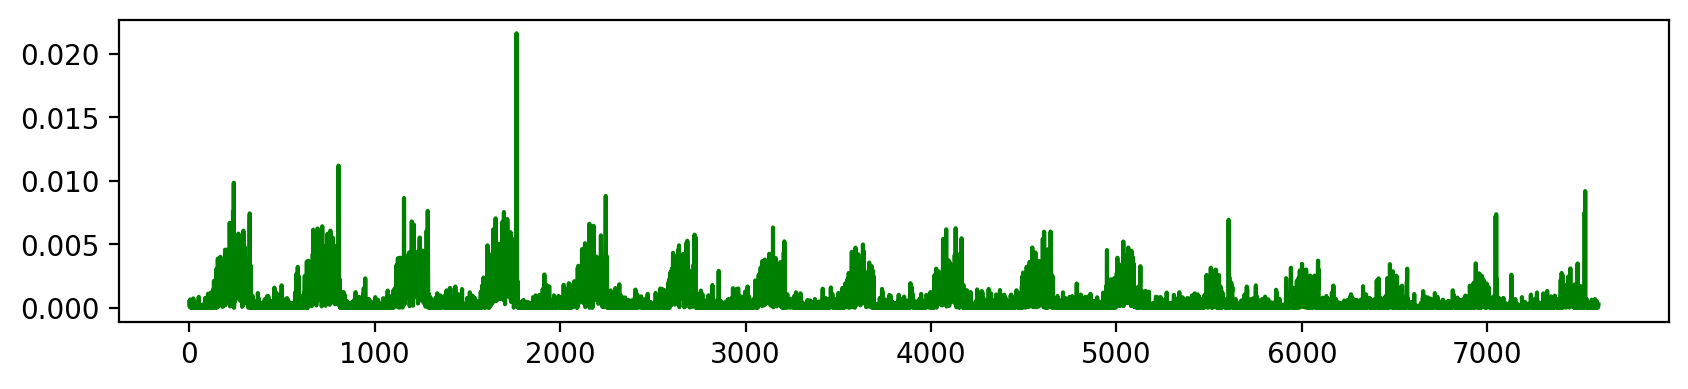

<IPython.core.display.Javascript object>

In [44]:
fig = plt.plot(train_reconerr_2, color="g")

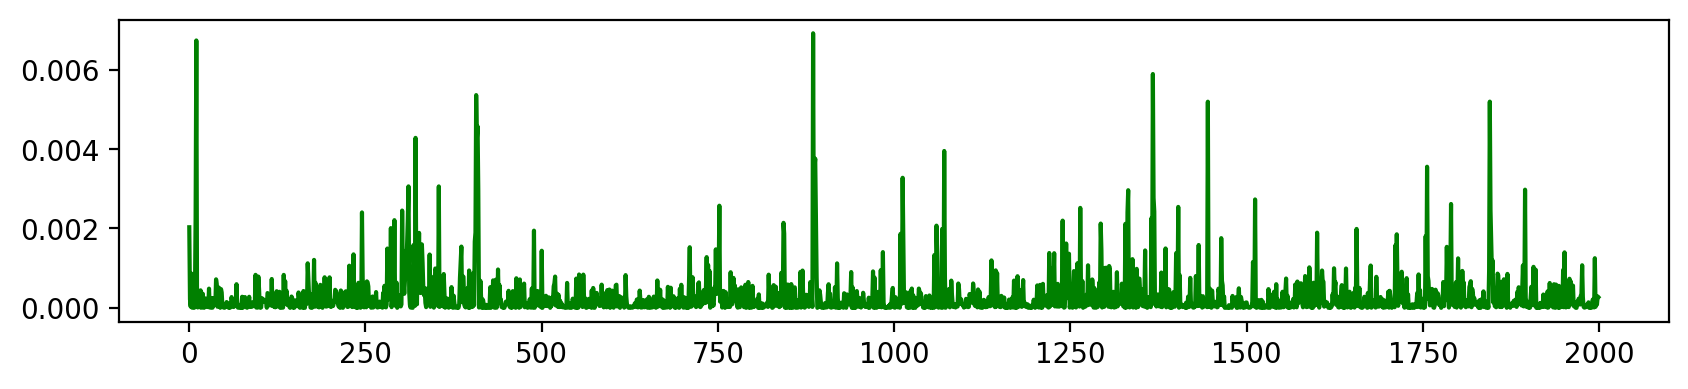

<IPython.core.display.Javascript object>

In [45]:
fig = plt.plot(val_reconerr_2, color="g")

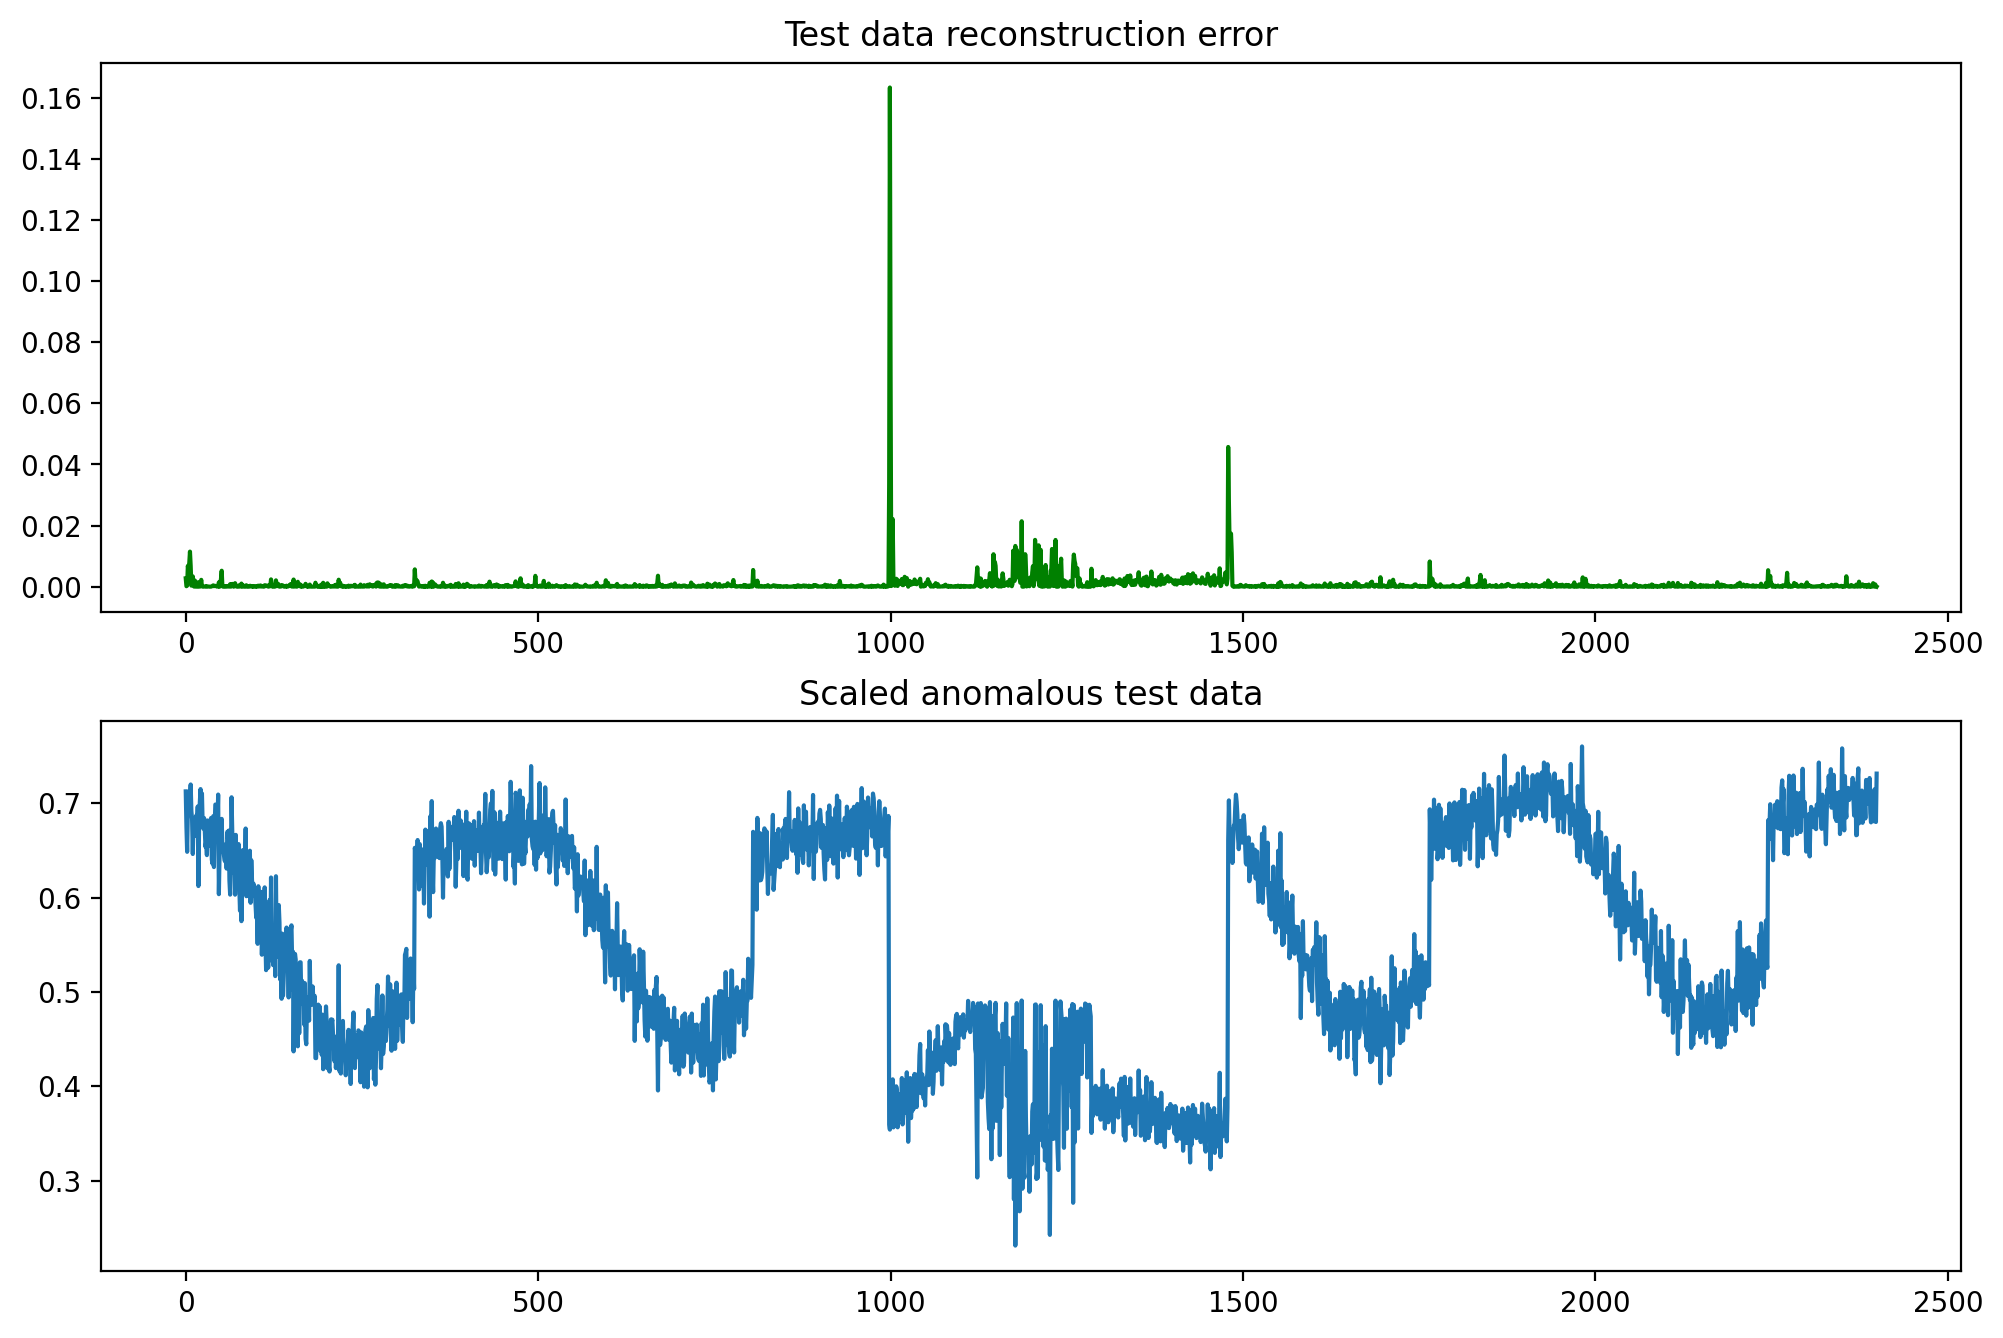

<IPython.core.display.Javascript object>

In [46]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
axes[0].set_title("Test data reconstruction error")
axes[1].set_title("Scaled anomalous test data")
_ = axes[0].plot(test_reconerr_2, color="g")
_ = axes[1].plot(x_test)

## Model 3
Using a similar architecture as model 2, but changing the number of filters/channels.

In [47]:
# with upsampling
model_3 = Conv1dAE(seq_len=SEQ_LEN, in_channels=1, enc_channels=[32, 4], enc_kernel_sizes=3)
model_3

Conv1dAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): ConvBlock(
        (conv): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (bnorm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): Conv1d(32, 4, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): ReLU()
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): ConvTransposeBlock(
        (convtranspose): ConvTranspose1d(4, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (bnorm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): Upsample(scale_factor=2.0, mode='linear')
      (2): ConvTranspose1d(32, 1, kernel_size=(3,), stride=(1,), padding=(1,))
    )
  )
)

<IPython.core.display.Javascript object>

In [48]:

trainer = TimeseriesTrainer(accelerator="cpu", max_epochs=MAX_EPOCHS, enable_progress_bar=True)
trainer.fit(model_3, train_dataloaders=DataLoader(StreamingDataset(x_train, seq_len=SEQ_LEN), batch_size=BATCH_SIZE))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=40` reached.


<IPython.core.display.Javascript object>

In [49]:
train_reconerr_3 = trainer.predict(
    model_3, dataloaders=DataLoader(train_dataset, batch_size=BATCH_SIZE)
).numpy()
val_reconerr_3 = trainer.predict(
    model_3, dataloaders=DataLoader(val_dataset,
                                    batch_size=BATCH_SIZE)
).numpy()
test_reconerr_3 = trainer.predict(
    model_3, dataloaders=DataLoader(test_dataset, batch_size=BATCH_SIZE)
).numpy()

<IPython.core.display.Javascript object>

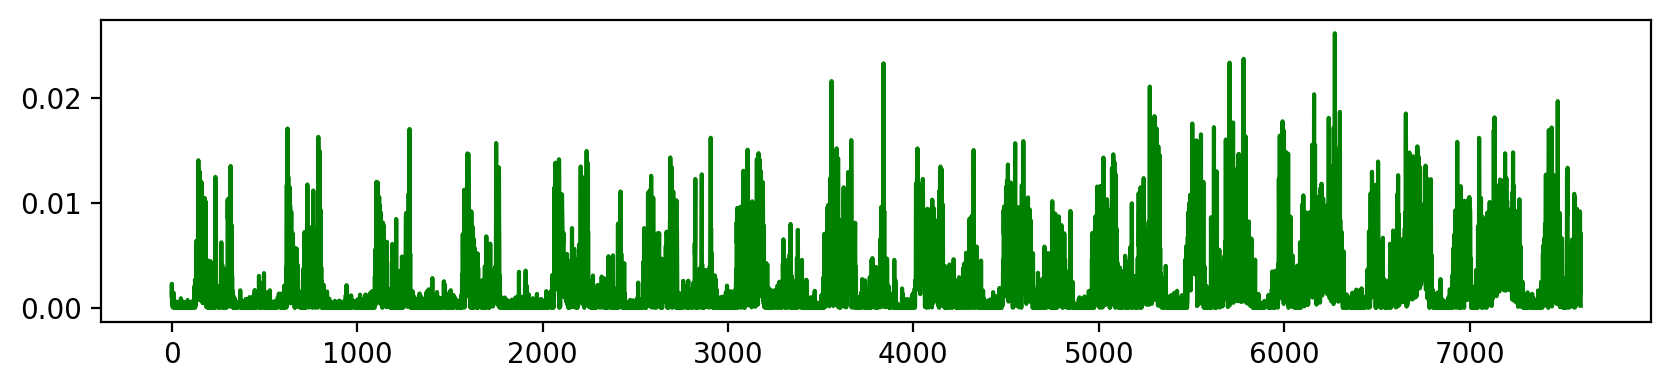

<IPython.core.display.Javascript object>

In [50]:
fig = plt.plot(train_reconerr_3, color="g")

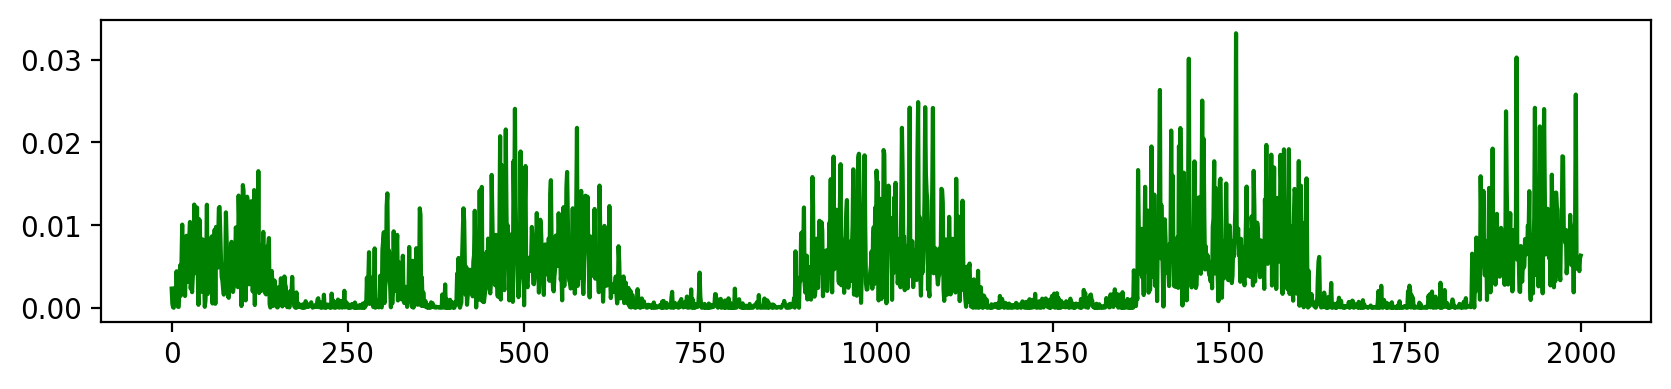

<IPython.core.display.Javascript object>

In [51]:
fig = plt.plot(val_reconerr_3, color="g")

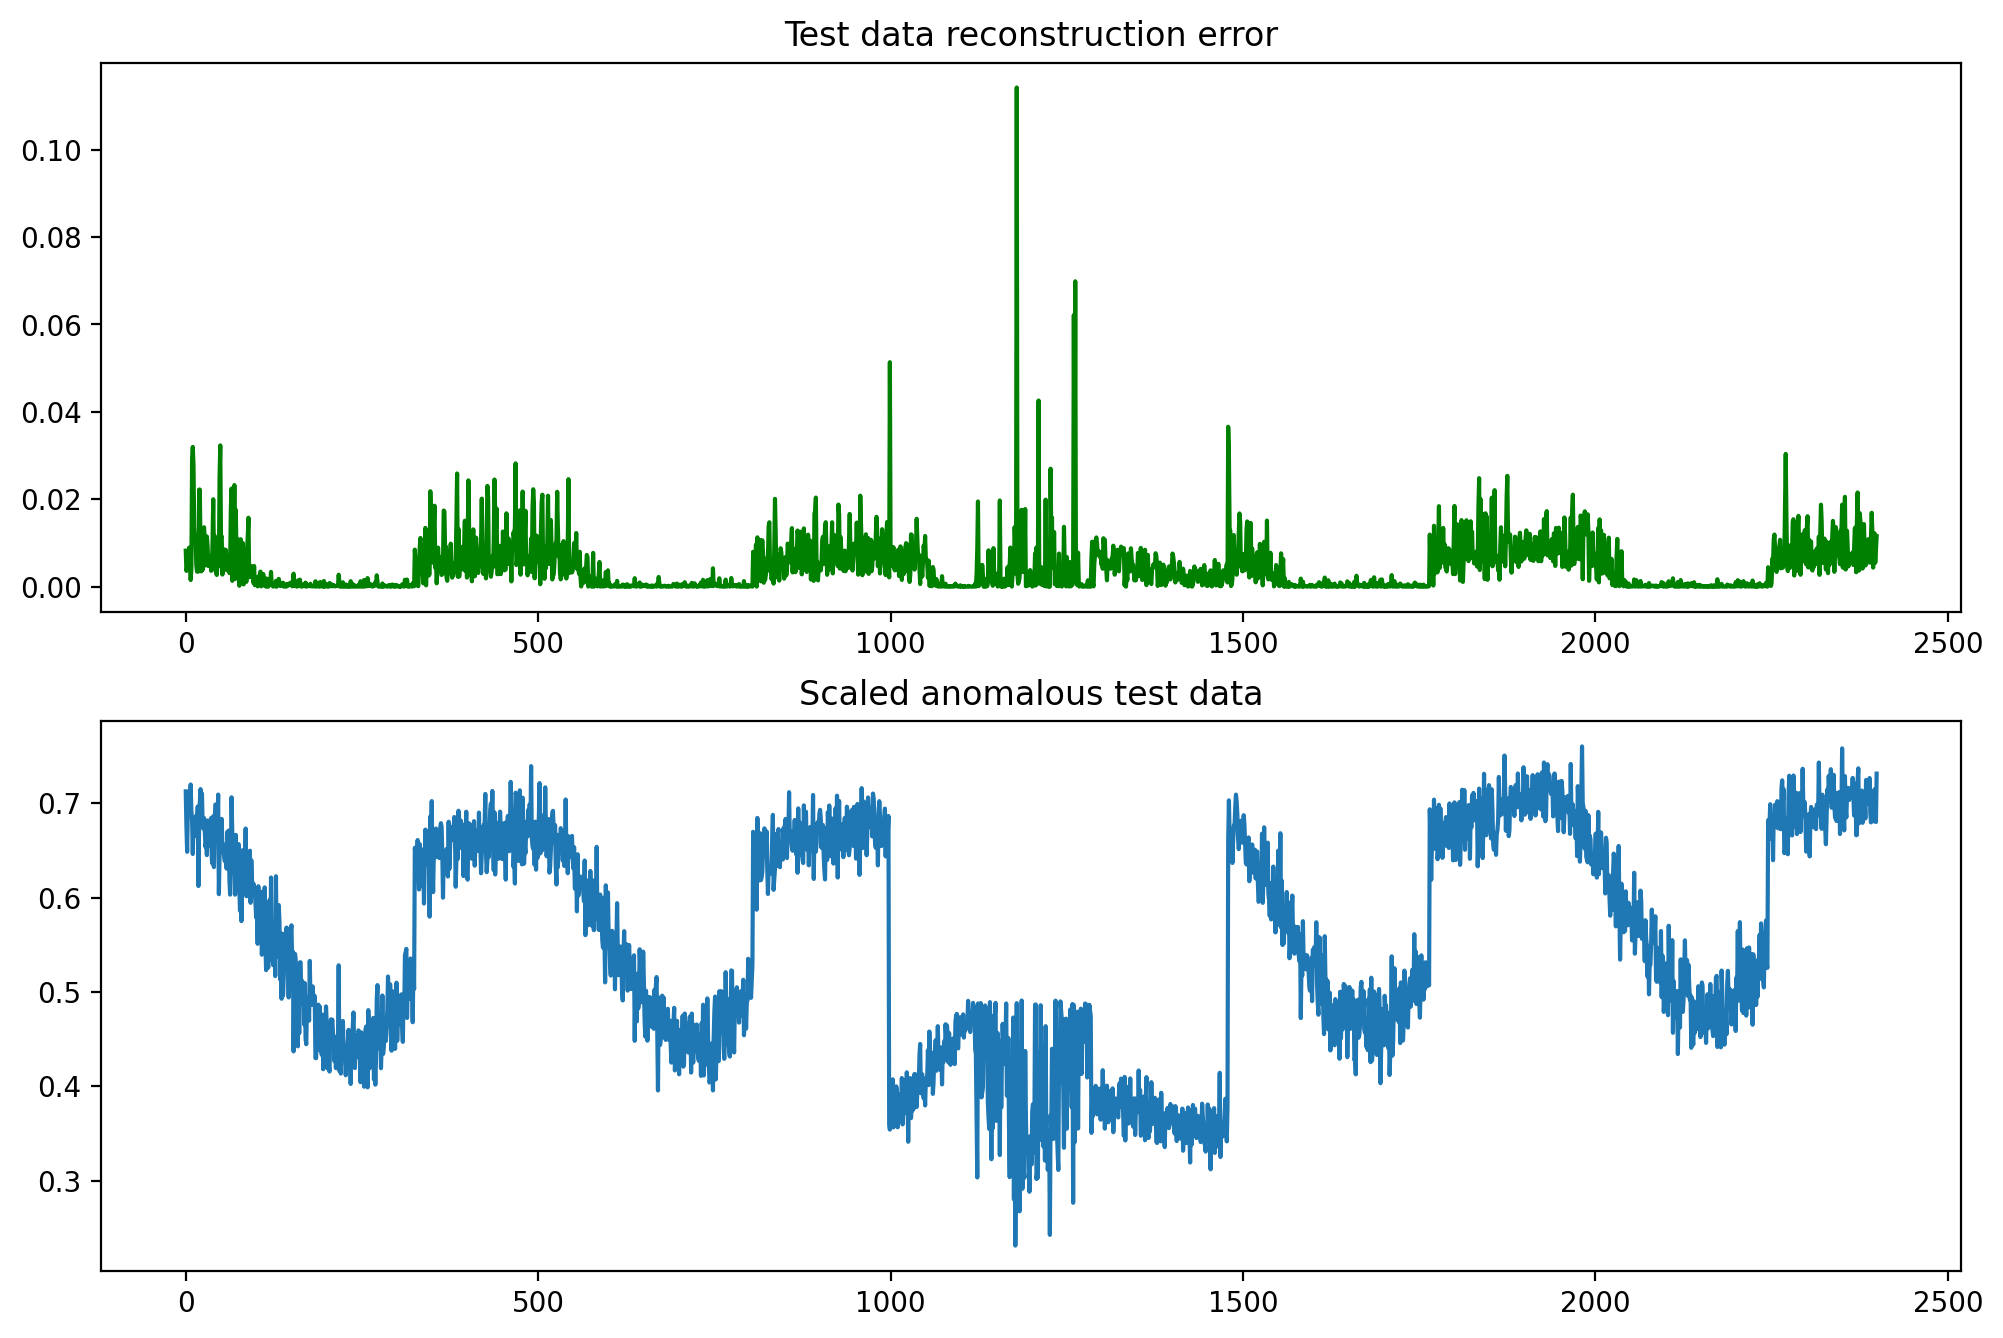

<IPython.core.display.Javascript object>

In [52]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
axes[0].set_title("Test data reconstruction error")
# axes[0].set_ylim(0, 0.5)
axes[1].set_title("Scaled anomalous test data")
_ = axes[0].plot(test_reconerr_3, color="g")
_ = axes[1].plot(x_test)

## Comparing the test reconstructions for the different models

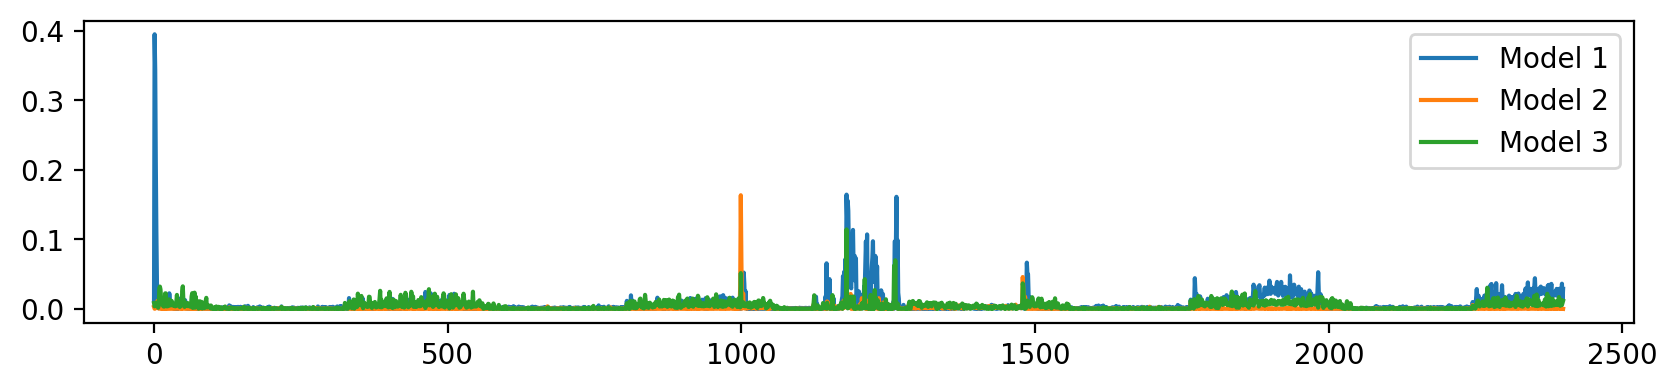

<IPython.core.display.Javascript object>

In [53]:
fig, ax = plt.subplots()
ax.plot(test_reconerr_1, label="Model 1")
ax.plot(test_reconerr_2, label="Model 2")
ax.plot(test_reconerr_3, label="Model 3")
plt.legend()